In [1]:
import sys
sys.path.append('../src')

In [2]:
import common.config as cfg
from common.nb_utils import estimate_optimal_ncomponents, pca_transform
from common.utils import get_device, Struct
from data.loader import get_testloader, get_trainloader
import matplotlib.pyplot as plt
from models.fcn import FCN
from models.resnet import resnet18
from models.model_op import get_model_grads, gradient_approximation
from models.svm import SVM
import models.resnet as resnet
import numpy as np
import pickle as pkl
import torch as t
import time
from tqdm.notebook import tqdm

In [3]:
dataset = 'cifar'
input_size = cfg.input_sizes[dataset]
output_size = cfg.output_sizes[dataset]
lr = 1e-1
sdirs_algo = 'pca' # 'qr'
bs = 16
epochs = 20

In [4]:
device = t.device('cuda:2')
loss = t.nn.CrossEntropyLoss().to(device)

In [5]:
trainloader = get_trainloader(dataset, bs, True)
testloader = get_testloader(dataset, bs, True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
sdirs = []
m = 6
n_accum = m*50
for idx, (data, labels) in tqdm(enumerate(trainloader), total=len(trainloader), leave=False):
    x, y = data.to(device), labels.to(device)
    model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
    optimizer = t.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    y_hat = model(x)
    loss_val = loss(y_hat, y)
    loss_val.backward()
    sdirs.append(get_model_grads(model))
    if idx == n_accum:
        break

# pretraining

In [10]:
trainloader = get_trainloader(dataset, 256, False)
testloader = get_testloader(dataset, 256, False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

correcti = 0
x_test = 0
for idx, (data, labels) in enumerate(testloader):
    x, y = data.to(device), labels.to(device)
    y_hat = model(x)
    loss_val = loss(y_hat, y)
    predi = y_hat.argmax(1, keepdim=True)
    correcti += predi.eq(y.view_as(predi)).sum().item()
y_test = correcti/len(testloader.dataset)
x_test, y_test

(0, 0.0805)

# w/o gradient approximation

In [12]:
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xb_train, yb_train = [], []
xb_test, yb_test =[], []
for _ in tqdm(range(1, epochs+1), leave=False):
    xb_train.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xb_train[-1], loss_val.item(), yb_train[-1], yb_test[-1]
    ))

1 	 1.8116 	 0.41 	 0.45
2 	 1.3324 	 0.57 	 0.55
3 	 1.5357 	 0.66 	 0.60
4 	 1.6865 	 0.73 	 0.58
5 	 1.6764 	 0.78 	 0.64
6 	 1.4122 	 0.82 	 0.64
7 	 2.1281 	 0.85 	 0.65
8 	 2.0723 	 0.89 	 0.63
9 	 1.3364 	 0.90 	 0.66
10 	 2.0341 	 0.92 	 0.66
11 	 2.3444 	 0.94 	 0.63
12 	 1.8000 	 0.95 	 0.67
13 	 2.5264 	 0.96 	 0.67
14 	 2.8772 	 0.97 	 0.68
15 	 1.9920 	 0.97 	 0.68
16 	 3.8344 	 0.98 	 0.67
17 	 4.0237 	 0.98 	 0.69
18 	 2.6924 	 0.98 	 0.68
19 	 4.2781 	 0.98 	 0.67
20 	 2.8787 	 0.99 	 0.69


# gradient approximation using n directions

In [13]:
n = 1
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xe_train, ye_train = [], []
xe_test, ye_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xe_train.append(_)
    xe_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            [sdirs[idx]], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xe_train[-1], loss_val.item(), ye_train[-1], ye_test[-1]
    ))

1 	 2.2521 	 0.10 	 0.12
2 	 2.2237 	 0.11 	 0.11
3 	 2.4513 	 0.11 	 0.12
4 	 2.2002 	 0.12 	 0.12
5 	 2.2442 	 0.12 	 0.12
6 	 2.0554 	 0.12 	 0.12
7 	 2.3996 	 0.12 	 0.13
8 	 3.0536 	 0.12 	 0.12
9 	 2.8178 	 0.13 	 0.13
10 	 3.5808 	 0.13 	 0.12
11 	 3.1469 	 0.13 	 0.13
12 	 2.6063 	 0.13 	 0.13
13 	 2.9978 	 0.13 	 0.13
14 	 2.9811 	 0.13 	 0.13
15 	 3.3942 	 0.13 	 0.13
16 	 3.0704 	 0.13 	 0.13
17 	 3.9713 	 0.14 	 0.14
18 	 4.1175 	 0.14 	 0.13
19 	 4.5215 	 0.14 	 0.13
20 	 4.0296 	 0.15 	 0.14


In [14]:
n = 10
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xc_train, yc_train = [], []
xc_test, yc_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xc_train.append(_)
    xc_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx:idx+n], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xc_train[-1], loss_val.item(), yc_train[-1], yc_test[-1]
    ))

1 	 3.4564 	 0.10 	 0.11
2 	 5.5912 	 0.11 	 0.13
3 	 6.4935 	 0.13 	 0.13
4 	 4.8606 	 0.15 	 0.16
5 	 3.8762 	 0.17 	 0.16
6 	 3.5521 	 0.18 	 0.17
7 	 2.6685 	 0.19 	 0.20
8 	 2.4586 	 0.20 	 0.20
9 	 2.6326 	 0.20 	 0.20
10 	 3.2054 	 0.21 	 0.21
11 	 3.3688 	 0.21 	 0.22
12 	 3.3465 	 0.22 	 0.22
13 	 3.3177 	 0.22 	 0.21
14 	 3.3357 	 0.23 	 0.22
15 	 2.9141 	 0.23 	 0.22
16 	 2.9897 	 0.23 	 0.22
17 	 2.6919 	 0.23 	 0.23
18 	 3.2098 	 0.23 	 0.23
19 	 3.3937 	 0.24 	 0.23
20 	 3.3229 	 0.25 	 0.24


In [ ]:
n = 100
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xd_train, yd_train = [], []
xd_test, yd_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xd_train.append(_)
    xd_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx:idx+n], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xd_train[-1], loss_val.item(), yd_train[-1], yd_test[-1]
    ))

1 	 6.4768 	 0.11 	 0.10
2 	 4.8594 	 0.11 	 0.11
3 	 3.8907 	 0.13 	 0.10


clf_resnet18_cifar_algo_pca_bs_16_sgd_vs_sgd_approx_random_grad_sampling


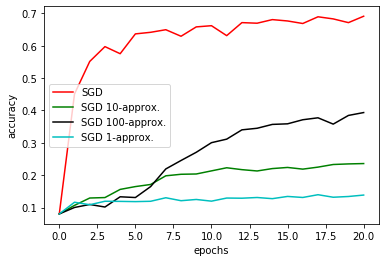

In [18]:
plt.figure()
plt.plot([x_test]+xb_train, [y_test]+yb_test, label='SGD', c='r')
# plt.plot([x_test]+xa_train, [y_test]+ya_test, label='SGD {}-approx.'.format(len(sdirs)), c='b')
plt.plot([x_test]+xc_train, [y_test]+yc_test, label='SGD 10-approx.', c='g')
plt.plot([x_test]+xd_train, [y_test]+yd_test, label='SGD 100-approx.', c='k')
plt.plot([x_test]+xe_train, [y_test]+ye_test, label='SGD 1-approx.', c='c')

history = {
    'test': [x_test, y_test],
#     'a': [xa_train, ya_train, xa_test, ya_test],
    'b': [xb_train, yb_train, xb_test, yb_test],
    'c': [xc_train, yc_train, xc_test, yc_test],
    'd': [xd_train, yd_train, xd_test, yd_test],
    'e': [xe_train, ye_train, xe_test, ye_test],
}

name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_grad_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(name)

pkl.dump(history, open('../ckpts/history/{}.pkl'.format(name), 'wb'))

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(
    '../ckpts/plots/{}.png'.format(name), 
    dpi=300, bbox_inches='tight'
)